# Skalierbarkeitstest der Spotify-Datenanalye

## Einführung
In diesem Notebook wird die **Skalierbarkeit** von Spark-Transformationen untersucht. Dazu wurde der **Input-Datensatz schrittweise vergrößert**, und die **Durchlaufzeiten der Transformationen** wurden gemessen. Ziel ist es, zu verstehen, wie sich die Performance verändert, wenn die Datenmenge steigt. *(Ergebnisse hinter jeder Zelle)*

Zusätzlich wurden folgende Faktoren getestet bzw. diskutiert *(Ergebnisse am Ende des Notebooks)*:  
- Wie verändert sich die Leistung mit **mehr oder weniger Knoten** im Cluster?  
- Wie beeinflusst die **Anzahl der Partitionen** die Durchlaufzeiten?  

## Testumgebung

Ein Scaling-Test wurde immer nur auf einem Rechner durchgeführt um verfälschte Ergebnisse zu vermeiden. Die Hard- und Software-Spezifikationen waren dabei jedoch die selben. Die folgenden Hard- und Software-Spezifikationen wurden für die Skalierungsbeobachtungen verwendet:  

- **CPU**: 8 Kerne  
- **RAM**: 16 GB  
- **Datengröße**: Ursprünglich 40 MB → Skaliert auf bis zu ca. 90 GB

Wenn Größen im Test angepasst/verändert wurden, ist dies explizit angegeben.

## Zielsetzung
Das Notebook und die hier durchfegührten Tests sollen zeigen, wie sich die Performance von der Musikdaten-Analyse verhält, wenn:  
1. Die **Datenmenge steigt**  
2. Die **Anzahl der verfügbaren Knoten variiert**  
3. Die **Anzahl der Partitionen angepasst wird**  

Im weiteren Verlauf dieses Notebooks werden die Testergebnisse analysiert und visualisiert.

---


#### 1. Datenvorbereitung

Im folgenden Abschnitt werden lediglich die benötigten Datenquellen geladen und die Spark-Session initialisiert.  

**Hinweis:** Dieser Abschnitt dient ausschließlich der Datenvorbereitung. Die hier durchgeführten Operationen werden **nicht auf Skalierbarkeit getestet**.  
Die eigentlichen Skalierbarkeitstests beginnen in den folgenden Zellen.


In [3]:
import os
import pickle
import findspark
[...]

#### 2. Daten laden und verarbeiten  

Diese Zelle lädt eine CSV-Datei und mehrere Pickle-Dateien, verarbeitet sie parallel und führt sie über die `track_uri` zusammen.  
Fehlerhafte Einträge werden gefiltert.


In [4]:
# CSV File einlesen: quote berücksichtigt das Inhalte zwischen " " als eine Spalte genommen werden
csv_df = spark.read.option("header", True).option("quote", '"').option("inferSchema", True).csv(csv_path)

# Alle Pickle-Dateien sammeln
pickle_files = [os.path.join(pickle_dir, f) for f in os.listdir(pickle_dir) if f.endswith(".pkl") or f.endswith(".pickle")]

# RDD erstellen basierend auf der Liste der Pickle-Dateien
pickle_rdd = spark.sparkContext.parallelize(pickle_files)

# Funktion zur Verarbeitung einer einzelnen Pickle-Datei
def process_pickle(filepath):
    try:
        with open(filepath, "rb") as file:
            pickle_data = pickle.load(file)
        
        # Extrahiere die benötigten Felder
        return {
            "track_uri": pickle_data.get("track_uri", "Unbekannt"),
            "bars": pickle_data.get("bars", []),
            "duration_ms": pickle_data.get("duration_ms", "Unbekannt"),
            "sections": pickle_data.get("sections", []),
            "segments": pickle_data.get("segments", []),
            "loudness_max": pickle_data.get("loudness_max", "Unbekannt"),
            "keys": pickle_data.get("keys", []),
            "track": pickle_data.get("track", [])
        }
    except Exception as e:
        return {"track_uri": None, "error": str(e)}

# Pickle-Dateien parallel verarbeiten
processed_rdd = pickle_rdd.map(process_pickle)

# RDD in Spark DataFrame umwandeln
pickle_df = spark.createDataFrame(processed_rdd, schema=schema)

# Fehlerhafte Einträge herausfiltern
valid_pickle_df = pickle_df.filter(pickle_df.track_uri.isNotNull())

# CSV-Daten mit Pickle-Daten verbinden
combined_df = valid_pickle_df.join(csv_df, valid_pickle_df["track_uri"] == csv_df["track_uri_csv"], how="inner")

#### Skalierungsergebnis: Datei-Input für CSV-Join und Filter

<div style="display: flex; justify-content: center; align-items: center; gap: 20px;">
  <div>
    <img src="../data/images/Input1.png" alt="Pickle Dateien" width="600"/>
  </div>
  <div>
    <table>
      <thead>
        <tr>
          <th>Pickle-Dateien</th>
          <th>Größe</th>
          <th>Durchlaufzeit (min)</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>100</td>
          <td>40 MB</td>
          <td>0,23</td>
        </tr>
        <tr>
          <td>1.000</td>
          <td>400 MB</td>
          <td>0,64</td>
        </tr>
        <tr>
          <td>5.000</td>
          <td>2 GB</td>
          <td>1,73</td>
        </tr>
        <tr>
          <td>10.000</td>
          <td>3,5 GB</td>
          <td>4,26</td>
        </tr>
        <tr>
          <td>50.000</td>
          <td>17,5 GB</td>
          <td>21,74</td>
        </tr>
        <tr>
          <td>100.000</td>
          <td>36,5 GB</td>
          <td>45,61</td>
        </tr>
        <tr>
          <td>150.000</td>
          <td>53,5 GB</td>
          <td>64,17</td>
        </tr>
        <tr>
          <td>200.000</td>
          <td>73 GB</td>
          <td>81,12</td>
        </tr>
        <tr>
          <td>250.000</td>
          <td>89 GB</td>
          <td>90,32</td>
        </tr>
      </tbody>
    </table>
  </div>
</div>


#### Auswirkung zunehmender Datenmenge
Mit wachsender Anzahl an Pickle- und CSV-Dateien steigt die Verarbeitungszeit. Die parallele Verarbeitung der Pickle-Dateien durch die Nutzung von RDDs (`parallelize` und `map`) skaliert gut, da jede Datei unabhängig verarbeitet wird. Allerdings kann die anschließende Erstellung des DataFrames und das Filtern der fehlerhaften Einträge zusätzliche Ressourcen beanspruchen. Die größte Herausforderung ist das Verbinden (`join`) der CSV- und Pickle-Daten. Dieser Schritt erfordert globales Shuffeling der Daten und wird bei großen Datensätzen signifikant teurer.

#### Ressourcenbelastung
Die **Verarbeitung der Pickle-Dateien** ist hauptsächlich **CPU-bound**, da sie Dateioperationen und Datenextraktionen umfasst. Der **Join-Schritt** zwischen den Pickle- und CSV-Daten ist sowohl **IO-bound** als auch **Memory-bound**, da die Daten über Partitionen hinweg abgeglichen und gespeichert werden müssen. Insbesondere bei unbalancierten Partitionen oder sehr großen Datensätzen kann dies zu Engpässen im Speicher oder zu langsamen Festplattenzugriffen führen.

#### Skalierbarkeit
Die Verarbeitung der Pickle-Dateien skaliert gut, da jede Datei unabhängig verarbeitet wird. Die Erstellung des DataFrames aus dem RDD ist ebenfalls gut skalierbar, solange die Partitionierung effektiv bleibt. Der Join ist jedoch ein kritischer Engpass, da er globale Datenbewegungen und Abstimmungen erfordert. Optimierungen könnten darin bestehen, die Daten vorab zu partitionieren, um die Join-Operation zu beschleunigen, oder alternative Join-Strategien zu verwenden, wie z. B. Broadcast-Joins, wenn die CSV-Daten klein genug sind, um in den Speicher geladen zu werden.


---


#### 3. Debugging-Informationen  

Diese Zelle beinhaltet keine relevante Datenverarbeitung. Sie dient primär der Fehlertoleranz und wird darum **nicht auf Sklaierbarkeit geprüft**.

In [5]:
# Join-Information fürs Debugging
[...]

# Statistik anzeigen
[...]

JOIN Information:
- Zeilen vor Join: 1000
- Zeilen nach Join: 1000

Erfolgs-Statistik:
- Gesamtanzahl der Dateien: 1000
- Erfolgreich verarbeitet: 1000
- Fehlerhaft: 0



---


#### 4. Berechnung des Modes (Major = 1 und Minor = 0) und daraus der Prozentsatz von Major (Dur)

In dieser Zelle wird der **Durchschnittsmodus** für alle Songs im Datensatz berechnet. Dabei wird der Anteil der Songs in einer **Dur-Tonart (Major)** als Prozentsatz ermittelt.  

In [6]:
# Berechnung des Durchschnittsmodus und Major-Prozentsatz für alle Songs
# Erstelle eine neue Spalte, die 1 ist, wenn der Modus 'Major' (1) ist, sonst 0
combined_df = combined_df.withColumn("is_major", F.when(combined_df["mode"] == 1, 1).otherwise(0))

# Gruppiere nach einer geeigneten Ebene (falls erforderlich, z.B. über alle Daten)
mode_stats = combined_df.agg(round(F.mean("is_major")*100,2).alias("major_percentage"))

# Ergebnisse anzeigen
mode_stats.show()

+----------------+
|major_percentage|
+----------------+
|            65.6|
+----------------+



#### Skalierungsergebnis: Datei-Input bei Modus-Analyse

<div style="display: flex; justify-content: center; align-items: center; gap: 20px;">
  <div>
    <img src="../data/images/input2.png" alt="Pickle Dateien" width="600"/>
  </div>
  <div>
    <table>
      <thead>
        <tr>
          <th>Pickle-Dateien</th>
          <th>Größe</th>
          <th>Durchlaufzeit (min)</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>100</td>
          <td>40 MB</td>
          <td>0,09</td>
        </tr>
        <tr>
          <td>1.000</td>
          <td>400 MB</td>
          <td>0,17</td>
        </tr>
        <tr>
          <td>5.000</td>
          <td>2 GB</td>
          <td>0,74</td>
        </tr>
        <tr>
          <td>10.000</td>
          <td>3,5 GB</td>
          <td>1,58</td>
        </tr>
        <tr>
          <td>50.000</td>
          <td>17,5 GB</td>
          <td>9,97</td>
        </tr>
      </tbody>
    </table>
  </div>
</div>

#### Auswirkung zunehmender Datenmenge
Mit steigender Datenmenge nimmt die Laufzeit moderat zu, da Spark die Berechnung des Durchschnittswerts (`mean`) effizient auf Partitionsebene durchführt. Allerdings erfordert die Aggregation eine Kombination der Ergebnisse aus allen Partitionen, was bei sehr großen Datenmengen zu einer leicht überproportionalen Zunahme der Laufzeit führen kann. Insgesamt bleibt der Ansatz jedoch skalierbar, solange die Partitionierung und die Clusterressourcen ausreichend dimensioniert sind.

#### Ressourcenbelastung
Die Berechnung des Major-Prozentsatzes (`mean`) ist vor allem CPU-bound, da Spark für jede Partition den Mittelwert berechnet und die Ergebnisse anschließend kombiniert. Dieser Prozess ist vergleichsweise ressourcenschonend, da keine zusätzlichen Daten zwischen Partitionen verschoben werden müssen (kein Shuffle). Speicherprobleme treten nicht auf, da die Berechnung auf aggregierten Werten basiert.

#### Skalierbarkeit
Die Berechnung des Major-Prozentsatzes ist gut skalierbar, da sie pro Partition unabhängig durchgeführt werden kann. Der einzige Engpass könnte bei einer extrem hohen Anzahl von Partitionen auftreten, da die Kombination der aggregierten Ergebnisse zusätzliche Zeit erfordert. Optimierungen wie eine angepasste Partitionierung oder Zwischenspeicherung könnten die Performance bei sehr großen Datenmengen weiter verbessern.

---


#### 5. Berechnung von Spaltenwerten und Sortierung  

In dieser Zelle werden verschiedene neue Spalten berechnet, darunter die **Dauer in Sekunden**, die **Anzahl der Segmente pro Sekunde** und der **Kehrwert der Sections pro Sekunde**. Anschließend wird die Tabelle anhand der berechneten Werte sortiert. Zusätzlich wird die **Korrelation zwischen Sections und Segments pro Sekunde** ermittelt.


In [10]:
results_df = combined_df.select(
    "name",
    (col("duration_ms").cast("float") / 1000).alias("duration_sec"),  # Dauer in Sekunden
    F.round(
        when(col("duration_ms") > 0, 
             1 / (size(col("sections")) / (col("duration_ms").cast("float") / 1000))
        ).otherwise(None), 2).alias("sections_per_second_reciprocal"),  # Gerundeter Kehrwert sections pro Sekunde
    F.round(
        when(col("duration_ms") > 0, 
             size(col("segments")) / (col("duration_ms").cast("float") / 1000)
        ).otherwise(0), 2).alias("segments_pro_sekunde")  # Gerundete segments pro Sekunde
).orderBy(col("sections_per_second_reciprocal").desc())  # Sortierung nach Sekunden pro Section absteigend

# Berechnung der Korrelation zwischen sections_pro_sekunde und segments_pro_sekunde
correlation = results_df.stat.corr("sections_per_second_reciprocal", "segments_pro_sekunde")

# Prüfen, ob das Ergebnis None ist, bevor es gerundet wird
correlation_rounded = py_round(correlation, 2) if correlation is not None else None

# Ausgabe der Korrelation
print(f"Korrelation zwischen sections_pro_sekunde und segments_pro_sekunde: {correlation_rounded}")

# Ergebnisse anzeigen
results_df.show(n=10, truncate=False)

Korrelation zwischen sections_pro_sekunde und segments_pro_sekunde: 0.06
+------------------------------------------------------------+------------+------------------------------+--------------------+
|name                                                        |duration_sec|sections_per_second_reciprocal|segments_pro_sekunde|
+------------------------------------------------------------+------------+------------------------------+--------------------+
|Dotted 8th & 16th Rhythm(Track 5 Disc 2)                    |192.333     |96.17                         |1.66                |
|Portal 3                                                    |370.961     |61.83                         |6.68                |
|Miedo                                                       |117.4       |58.7                          |2.8                 |
|Clouds & Cream                                              |174.347     |58.12                         |4.06                |
|Shurik'n                      

#### Skalierungsergebnis: Datei-Input bei Sections-Korrelation 

<div style="display: flex; justify-content: center; align-items: center; gap: 20px;">
  <div>
    <img src="../data/images/input3.png" alt="Pickle Dateien" width="600"/>
  </div>
  <div>
    <table>
      <thead>
        <tr>
          <th>Pickle-Dateien</th>
          <th>Größe</th>
          <th>Durchlaufzeit (min)</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>100</td>
          <td>40 MB</td>
          <td>0,2</td>
        </tr>
        <tr>
          <td>1.000</td>
          <td>400 MB</td>
          <td>0,76</td>
        </tr>
        <tr>
          <td>5.000</td>
          <td>2 GB</td>
          <td>1,83</td>
        </tr>
        <tr>
          <td>10.000</td>
          <td>3,5 GB</td>
          <td>3,72</td>
        </tr>
        <tr>
          <td>50.000</td>
          <td>17,5 GB</td>
          <td>22,66</td>
        </tr>
      </tbody>
    </table>
  </div>
</div>


#### Auswirkung zunehmender Datenmenge
Mit steigender Datenmenge erhöht sich die Laufzeit der Verarbeitung, da für jede Zeile neue Spalten berechnet und die Daten sortiert werden. Besonders die Berechnung von "Anzahl Sekunden pro Section (Kehrwert)" und "segments_pro_sekunde" erfordert eine Transformation für jede Zeile, was bei großen Datensätzen zu einer proportionalen Zunahme der Laufzeit führt. Die Sortierung (`orderBy`) ist hingegen ein kritischer Punkt, da Spark hierfür die Daten über alle Partitionen hinweg abstimmen muss, was mit zunehmender Datenmenge zu einer signifikanten Steigerung der Laufzeit führen kann.

#### Ressourcenbelastung
Die Berechnung der neuen Spalten ist vor allem CPU-bound, da sie auf Zeilenebene durchgeführt wird. Die Sortierung ist sowohl IO- als auch Memory-bound, da die Daten zwischen den Partitionen verschoben und im Speicher gehalten werden müssen, um die Reihenfolge sicherzustellen. Der größte Ressourcenverbrauch tritt bei der globalen Sortierung auf, da hierbei alle Partitionen synchronisiert werden müssen.

#### Skalierbarkeit
Die Berechnung der Spalten skaliert gut, da sie unabhängig für jede Partition durchgeführt werden kann. Die Sortierung ist jedoch schwieriger zu skalieren, da sie eine globale Abstimmung der Daten erfordert, was mit einer steigenden Anzahl von Partitionen und Datenzeilen ineffizienter wird. Eine mögliche Verbesserung wäre die Verwendung einer optimierten Partitionierung oder der Verzicht auf eine vollständige Sortierung, falls nur eine Teilmenge der Daten benötigt wird.

---


#### 6. Korrelationen zwischen Energy, Loudness Max und Danceability  

In dieser Zelle werden die **Zusammenhänge zwischen den musikalischen Merkmalen "Energy", "Loudness Max" und "Danceability"** untersucht. Dazu wird die geschachtelte `segments`-Spalte explodiert, um für jeden Song die maximale Lautstärke (`loudness_max`) zu extrahieren. Anschließend werden die Werte gefiltert, um ungültige Einträge zu entfernen, und die Korrelationen zwischen den Variablen berechnet.

In [8]:
# Schritt 1: Sicherstellen, dass die Spalten den Typ "double" haben
combined_df = combined_df.withColumn("energy", combined_df["energy"].cast("double")).withColumn("danceability", combined_df["danceability"].cast("double"))

# Schritt 2: Explodieren der "segments"-Spalte und Extrahieren von "loudness_max"
# Hier Zugriff auf Information der Pickle Datei: Da diese eine geschachtelte Struktur enthält, muss zunächst auf Segments zugegriffen werden und anschließend auf loudness max
exploded_df = combined_df.withColumn("segment", F.explode("segments")).withColumn("loudness_max_segment", F.col("segment.loudness_max").cast("double"))

# Schritt 3: Filtern der Zeilen, um null-Werte zu vermeiden und Berechnung der Korrelationen
filtered_df = exploded_df.filter((F.col("energy").isNotNull()) & (F.col("danceability").isNotNull()) & (F.col("loudness_max_segment").isNotNull()))

# Berechnung der Korrelationen
corr_energy_loudness_max = filtered_df.stat.corr("energy", "loudness_max_segment")
corr_loudness_max_danceability = filtered_df.stat.corr("loudness_max_segment", "danceability")
corr_energy_danceability = filtered_df.stat.corr("energy", "danceability")
                                                              
correlation_energy_loudness_max = py_round(corr_energy_loudness_max, 2) if corr_energy_loudness_max is not None else None
correlation_loudness_max_danceability = py_round(corr_loudness_max_danceability, 2) if corr_loudness_max_danceability is not None else None
correlation_energy_danceability = py_round(corr_energy_danceability , 2) if corr_energy_danceability is not None else None

# Ausgabe der Korrelationen
print(f"Korrelation zwischen Energy und Loudness Max: {correlation_energy_loudness_max}")
print(f"Korrelation zwischen Loudness Max und Danceability: {correlation_loudness_max_danceability}")
print(f"Korrelation zwischen Energy und Danceability: {correlation_energy_danceability}")

Korrelation zwischen Energy und Loudness Max: 0.63
Korrelation zwischen Loudness Max und Danceability: 0.32
Korrelation zwischen Energy und Danceability: 0.36


#### Skalierungsergebnis: Datei-Input bei Energy-Danceability Korrelation

<div style="display: flex; justify-content: center; align-items: center; gap: 20px;">
  <div>
    <img src="../data/images/input4.png" alt="Pickle Dateien" width="600"/>
  </div>
  <div>
    <table>
      <thead>
        <tr>
          <th>Pickle-Dateien</th>
          <th>Größe</th>
          <th>Durchlaufzeit (min)</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>100</td>
          <td>40 MB</td>
          <td>0,3</td>
        </tr>
        <tr>
          <td>1.000</td>
          <td>400 MB</td>
          <td>0,56</td>
        </tr>
        <tr>
          <td>5.000</td>
          <td>2 GB</td>
          <td>2,66</td>
        </tr>
        <tr>
          <td>10.000</td>
          <td>3,5 GB</td>
          <td>5,34</td>
        </tr>
        <tr>
          <td>50.000</td>
          <td>17,5 GB</td>
          <td>36,91</td>
        </tr>
      </tbody>
    </table>
  </div>
</div>


#### Auswirkung zunehmender Datenmenge  
Mit steigender Datenmenge wächst die Anzahl der entpackten Segmente exponentiell, da jeder Song mehrere Segmente enthält. Die `explode`-Operation vervielfacht daher die Zeilenanzahl, was die Verarbeitungszeit überproportional erhöht. Auch die Filterung wird teurer, da Spark alle Zeilen durchlaufen muss, um ungültige Werte zu entfernen. Die Berechnung der Korrelationen selbst bleibt jedoch effizient, da sie nur auf aggregierten Werten basiert.

#### Ressourcenbelastung  
Das Explodieren der `segments`-Spalte ist CPU- und Memory-bound, da jede Zeile aufgebrochen wird und das System eine stark wachsende Anzahl an Zeilen verwalten muss. Die Filterung und Umwandlung der Werte ist ebenfalls CPU-bound. Die Berechnung der Korrelationen ist hingegen ressourcenschonend, da nur ein Aggregationsschritt über die bereits bereinigten Daten erfolgt.

#### Skalierbarkeit  
Die `explode`-Operation ist schwer skalierbar, da sie die Datenmenge erheblich vergrößert. Eine Verbesserung könnte durch eine reduzierte Datenmenge oder eine angepasste Partitionierung erzielt werden. Die Filterung und Korrelationen sind hingegen gut skalierbar, da sie auf Partitionsebene durchgeführt werden können. Eine effizientere Speicherung oder Vorverarbeitung der Segmente könnte die Leistung weiter optimieren.

---


#### 7. Visualisierung von Zusammenhängen zwischen Energy, Loudness Max und Danceability  

In dieser Zelle werden die zuvor berechneten Werte für **Energy, Loudness Max und Danceability** visualisiert. Dazu wird eine Stichprobe von **10.000 Datenpunkten** gezogen, die in ein Pandas DataFrame umgewandelt wird. Anschließend werden **Hexbin-Diagramme** erstellt, um die Dichteverteilung der Punkte für verschiedene Merkmalskombinationen zu analysieren.


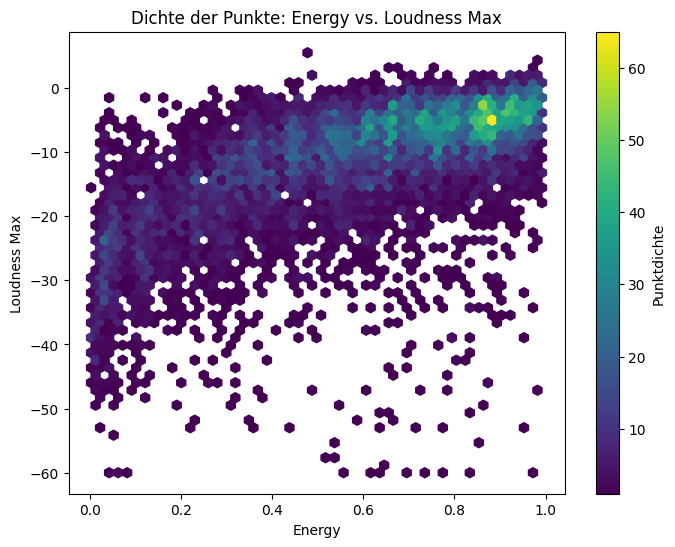

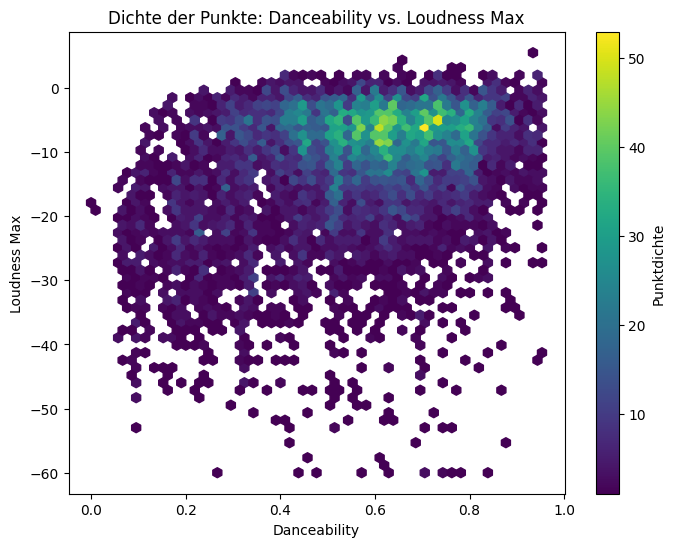

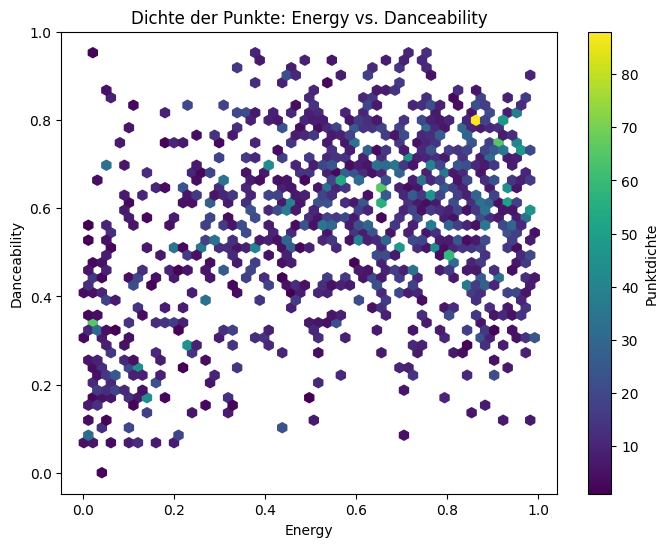

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

# Spark DataFrame vorbereiten
filtered_df = filtered_df.select(
    col("energy").cast("float"),
    col("loudness_max_segment").cast("float"),
    col("danceability").cast("float")
).na.drop()

# Sampling der Daten (10.000 Zeilen für Visualisierung)
sample_size = 10000
sampled_df = filtered_df.sample(fraction=sample_size / filtered_df.count())

# Umwandeln der Stichprobe in Pandas DataFrame
filtered_pd_df = sampled_df.toPandas()

# Visualisierung 1: Hexbin-Dichteplot für Energy vs. Loudness Max
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["energy"], filtered_pd_df["loudness_max_segment"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Energy vs. Loudness Max")
plt.xlabel("Energy")
plt.ylabel("Loudness Max")
plt.show()

# Visualisierung 2: Hexbin-Dichteplot für Danceability vs. Loudness Max
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["danceability"], filtered_pd_df["loudness_max_segment"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Danceability vs. Loudness Max")
plt.xlabel("Danceability")
plt.ylabel("Loudness Max")
plt.show()


#Visualisierung 3: Energy vs. Danceability
plt.figure(figsize=(8, 6))
plt.hexbin(filtered_pd_df["energy"], filtered_pd_df["danceability"], gridsize=50, cmap="viridis", mincnt=1)
plt.colorbar(label="Punktdichte")
plt.title("Dichte der Punkte: Energy vs. Danceability")
plt.xlabel("Energy")
plt.ylabel("Danceability")
plt.show()

#### Skalierungsergebnis: Datei-Input bei Clustering und Visualisierung

<div style="display: flex; justify-content: center; align-items: center; gap: 20px;">
  <div>
    <img src="../data/images/input5.png" alt="Pickle Dateien" width="600"/>
  </div>
  <div>
    <table>
      <thead>
        <tr>
          <th>Pickle-Dateien</th>
          <th>Größe</th>
          <th>Durchlaufzeit (min)</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>100</td>
          <td>40 MB</td>
          <td>0,21</td>
        </tr>
        <tr>
          <td>1.000</td>
          <td>400 MB</td>
          <td>0,41</td>
        </tr>
        <tr>
          <td>5.000</td>
          <td>2 GB</td>
          <td>1,73</td>
        </tr>
        <tr>
          <td>10.000</td>
          <td>3,5 GB</td>
          <td>3,71</td>
        </tr>
        <tr>
          <td>50.000</td>
          <td>17,5 GB</td>
          <td>23,75</td>
        </tr>
      </tbody>
    </table>
  </div>
</div>


#### Auswirkung zunehmender Datenmenge  
Mit steigender Datenmenge verlängert sich die Zeit für die Stichprobenbildung und die Umwandlung in ein Pandas DataFrame. Da Pandas nicht für verteilte Systeme optimiert ist, würde eine direkte Visualisierung ohne Sampling bei sehr großen Datensätzen zu Speicherproblemen führen. Durch das Sampling bleibt die Laufzeit jedoch stabil.

#### Ressourcenbelastung  
Die Umwandlung von Spark DataFrames in Pandas ist stark **Memory-bound**, da die Daten in den Arbeitsspeicher geladen werden. Die Stichprobenziehung ist **CPU-bound**, da Spark die Daten gleichmäßig aus den Partitionen verteilt. Die Visualisierung mit Matplotlib ist ebenfalls **CPU-bound**, insbesondere bei einer hohen Anzahl an Datenpunkten.

#### Skalierbarkeit  
Das Sampling skaliert gut, solange Spark die Daten effizient partitioniert. Die Umwandlung in Pandas und die Visualisierung sind jedoch schwer skalierbar, da sie auf **nicht-verteilten Bibliotheken** basieren. Eine skalierbare Alternative wäre der Einsatz von **Spark-kompatiblen Visualisierungstools** wie Databricks Visualizations oder Plotly.


### Fazit: Skalierbarkeit bei variierenden Input-Mengen


<img src="../data/images/Input-all.png" alt="Pickle Dateien" width="600"/>

| Pickle-Dateien | Größe   | CSV-Join und Filter | Modus-Analyse | Sections-Korrelation | Energy-Danceability Korrelation |
|----------------|---------|---------------------|---------------|-----------------------|----------------------------------|
| 100            | 40 MB   | 0,23               | 0,39          | 0,2                   | 0,3                              |
| 1.000          | 400 MB  | 0,64               | 1             | 0,76                  | 0,56                             |
| 5.000          | 2 GB    | 1,73               | 3,25          | 1,83                  | 2,66                             |
| 10.000         | 3,5 GB  | 4,26               | 6,3           | 3,72                  | 5,34                             |
| 50.000         | 17,5 GB | 21,74              | 31,3          | 22,66                 | 36,91                            |
| 100.000        | 36,5 GB | 45,61              |               |                       |                                  |
| 150.000        | 53,5 GB | 64,17              |               |                       |                                  |
| 200.000        | 73 GB   | 81,12              |               |                       |                                  |
| 250.000        | 89 GB   | 90,32              |               |                       |                                  |


Die Analyse zeigt, dass die Verarbeitung der Pickle-Dateien mit zunehmender Datenmenge erwartungsgemäß linear bis leicht überproportional ansteigt. Insbesondere die Schritte "Sections-Korrelation" und "Energy-Danceability Korrelation" sind datenintensiv und zeigen höhere Laufzeiten bei großen Datenmengen.

**Hauptpunkte:**
- **Lineare Reaktion der Leistung auf steigerung des Inputs:** Die Input-Tests zeigen sehr gut, dass bei steigendem Daten-Input und gleichbleibenden Ressourcen die Leistung linear zunimmt. Während die meisten Code-Zellen für bis zu 50.000 Dateien getestet wurden, wurde für "CSV-Join und Filter" die Skalierbarkeit von 100 bis 250.000 Dateien getestet. Vor allem hier werden die Vorteile der PySpark-Parallelisierung deutlich.
- **Grenzen:** Ab 200.000 Dateien verliert die lokale Umgebung an Effizienz - Cluster-Computing wäre für größere Datenmengen sinnvoll.
- **Optimierungspotenziale:** Man sollte sich überlegen Parquet statt Pickle zu nutzen. Außerdem würden leistungsfähigere Hardware die Performance auch verbessern.

**->** Es ist anzunehmen, auf Grundlage der Tests, dass die Implementierung bis zu 250.000 Dateien robust verarbeitet, jedoch bei größeren Datenmengen an ihre Grenzen stößt. Eine Optimierung der Architektur ist notwendig, um eine höhere Skalierbarkeit sicherzustellen.

---


### Ressourcen-Scaling-Test

Um die Skalierbarkeit des Spark-Codes bei unterschiedlicher Ressourcenverfügbarkeit zu bewerten, wurde die Anzahl der verfügbaren CPU-Kerne variiert. Die Tests wurden mit 1, 4 und 8 CPU-Kernen durchgeführt, während der Dateien-Input in Stufen von 50 bis 20.000 Dateien erhöht wurde. Ziel dieses Tests war es, die Auswirkungen der Kernanzahl auf die Durchlaufzeit zu untersuchen und festzustellen, ob die Verarbeitung proportional mit der Verfügbarkeit von Ressourcen skaliert.

### Ergebnisse und Erklärung der Durchlaufzeiten

<div style="display: flex; justify-content: center; align-items: center; gap: 20px;">
  <div>
    <img src="../data/images/Core1.png" alt="Skalierbarkeit_Zelle_3.png" width="600"/>
  </div>
  <div>
    <table>
      <thead>
        <tr>
          <th>Anzahl Dateien</th>
          <th>1 Kern</th>
          <th>4 Kerne</th>
          <th>8 Kerne</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>50</td>
          <td>0,56</td>
          <td>0,66</td>
          <td>0,95</td>
        </tr>
        <tr>
          <td>100</td>
          <td>0,63</td>
          <td>0,69</td>
          <td>0,90</td>
        </tr>
        <tr>
          <td>500</td>
          <td>1,22</td>
          <td>0,86</td>
          <td>1,02</td>
        </tr>
        <tr>
          <td>1000</td>
          <td>2,12</td>
          <td>1,11</td>
          <td>1,19</td>
        </tr>
        <tr>
          <td>5000</td>
          <td>7,90</td>
          <td>4,06</td>
          <td>2,63</td>
        </tr>
        <tr>
          <td>10.000</td>
          <td>14,45</td>
          <td>5,89</td>
          <td>4,70</td>
        </tr>
        <tr>
          <td>20.000</td>
          <td>28,94</td>
          <td>9,57</td>
          <td>8,00</td>
        </tr>
      </tbody>
    </table>
    <p><em>Zeitangaben sind in Minuten</em></p>
  </div>
</div>

Das Diagramm zeigt, dass die Durchlaufzeiten mit zunehmender Dateianzahl deutlich von der Parallelisierung profitieren. Die Unterschiede zwischen 1, 4 und 8 Kernen werden dabei immer deutlicher:

**Effizienz bei kleinen Datenmengen:**
Bei 5000 Dateien ist der Unterschied zwischen 4 und 8 Kernen gering, da der Parallelisierungsaufwand (z. B. Partitionierung und Kommunikation zwischen den Kernen) relativ hoch ist. Hier ist die Effizienz von Spark noch begrenzt, weil die Datenmenge zu klein ist, um den Overhead der Parallelisierung vollständig zu kompensieren.

**Bessere Skalierung bei größeren Datenmengen:**
Ab 10000 Dateien zeigt sich ein deutlicher Vorteil von 8 Kernen gegenüber 4 Kernen. Dies liegt daran, dass die Datenmenge groß genug ist, um den Parallelisierungsaufwand zu rechtfertigen. Die zusätzlichen Kerne können effektiv genutzt werden, was die Durchlaufzeiten weiter reduziert.

**Lineare Skalierung mit 1 Kern:**
Bei 1 Kern steigt die Durchlaufzeit linear mit der Dateianzahl, da keine Parallelisierung erfolgt. Das System arbeitet hier sequenziell, was bei größeren Datenmengen ineffizient ist.


<div style="display: flex; align-items: flex-start; gap: 20px;">
  <div>
    <img src="../data/images/Core2.png" alt="Skalierbarkeit_Zelle_3.png" width="600"/>
  </div>
  <div>
    <table>
      <thead>
        <tr>
          <th>Anzahl Dateien</th>
          <th>1 Kern</th>
          <th>4 Kerne</th>
          <th>8 Kerne</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>50</td>
          <td>0,56</td>
          <td>0,66</td>
          <td>0,95</td>
        </tr>
        <tr>
          <td>100</td>
          <td>0,63</td>
          <td>0,69</td>
          <td>0,90</td>
        </tr>
        <tr>
          <td>500</td>
          <td>1,22</td>
          <td>0,86</td>
          <td>1,02</td>
        </tr>
        <tr>
          <td>1000</td>
          <td>2,12</td>
          <td>1,11</td>
          <td>1,19</td>
        </tr>
      </tbody>
    </table>
    <p><em>Zeitangaben sind in Minuten</em></p>
  </div>
</div>



Dieses Diagramm zeigt die Durchlaufzeiten für 50 bis 1000 Dateien bei 1, 4 und 8 Kernen.

**Erklärung:**
Das Diagramm verdeutlicht, dass bei einer geringen Anzahl von Dateien die parallele Verarbeitung auf mehreren Kernen nicht effizient ist. Tatsächlich zeigt die Leistung bei 8 Kernen sogar eine höhere Durchlaufzeit als bei 1 oder 4 Kernen. Dies liegt daran, dass Apache Spark hauptsächlich für die Verarbeitung von großen Datenmengen optimiert ist, wo die Aufteilung der Aufgaben zwischen Kernen sinnvoll ist. Bei kleinen Datenmengen überwiegen jedoch die Overheads, wie z. B. die Kommunikation zwischen den Kernen und die Partitionierung, was zu einer Verschlechterung der Leistung führt.

---


### Erwarteter Einfluss der Partitionierung auf die Skalierbarkeit

Basierend auf dem Verständnis der Spark-Architektur lässt sich vermuten, dass die Wahl der Anzahl an Partitionen einen erheblichen Einfluss auf die Skalierbarkeit hat. **Zu wenige Partitionen** könnten dazu führen, dass nicht alle verfügbaren CPU-Kerne ausgelastet werden, wodurch Rechenressourcen ungenutzt bleiben und sich die Gesamtverarbeitung verlangsamt (*Unterpartitionierung*). 

Umgekehrt könnte eine **zu hohe Anzahl an Partitionen** zusätzlichen Verwaltungsaufwand verursachen, insbesondere durch erhöhte Shuffling-Kosten, wenn Daten zwischen den Partitionen bewegt werden müssen (*Überpartitionierung*). 

Eine **ausgewogene Partitionierung** dürfte daher den besten Kompromiss zwischen Rechenlastverteilung und Overhead bieten. Die genaue optimale Anzahl wäre jedoch abhängig von der Datenmenge, den Transformationen und der verfügbaren Hardware. 